#### <left>Бронников Максим Андреевич</left>

max120199@gmail.com

#   <center>Домашняя работа №3</center>

## <center> Необходимо построить регрессионную линейную модель по первой части набора данных и сделать прогноз о значении столбца второй части набора </center>

### Подключим необходимые библиотеки

Для обработки данных нам пригодится визуализация, которую обеспечит библиотека `matplotlib.pyplot`. Библиотека `pandas` позволит нам обработать набор данных и сохранить их в *DataFrame*, а с помощью библиотеки `numpy` реализуем математическую составляющую построения линейной регрессии в матричном виде

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for grafic

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
        

# Any results you write to the current directory are saved as output.

-----

### Импортируем набор данных

С помощью функции `reaf_csv` импортируем набор данных для тренировки. С помощью функции `head` получим представление о наборе данных взглянув на первые элементы из набора.

In [2]:
train_table = pd.read_csv('input/train.csv')
print("Размер таблицы для тренировки:", train_table.shape)
train_table.head()

Размер таблицы для тренировки: (782, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,20,RL,60.0,9060,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal,120000
1,1,20,FV,81.0,11216,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,New,Partial,232600
2,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2007,WD,Normal,175500
3,3,60,RL,NaN,11214,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,199900
4,4,90,RL,91.0,11643,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2009,WD,Normal,200000


-----

### Изобразим распределение 

Используем метод *DataFrame* `plot.scatter`предварительно создав окно отрисовки с помощью `figure` и `subplot` для отображения поточечно распределения значений колонки `SalePrice`, именно её значения нам и необходимо предсказать в тестовой части набора данных.

Посмотрим на общий график значения цены:


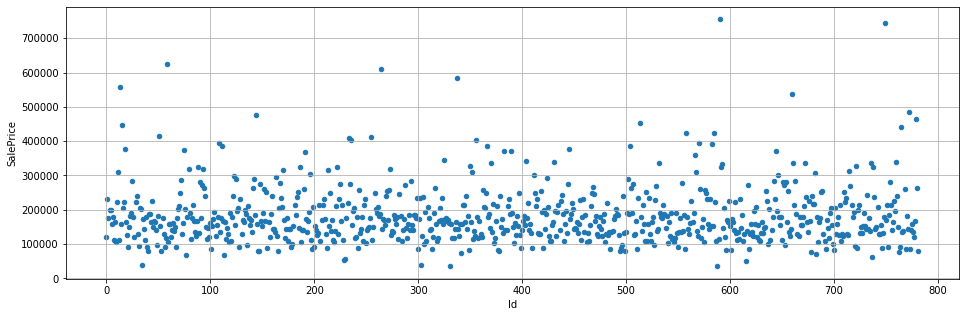

In [3]:
ig = plt.figure(figsize=(16,5))
ax1 = plt.subplot(111)

print("Посмотрим на общий график значения цены:")
train_table.plot.scatter('Id', 'SalePrice', ax = ax1)
ax1.grid()

-----

### Преобразоавние данных в математически преобразуемый вид

Преобразуем данные для обучения из *DataFrame* в *numpy.array* для последующей работы с ними при помощи метода `to_numpy`. Тоже самое выполним и для столбца `SalePrice` значения которого и следует предсказать. Приведем преобразованные данные к необходимому размеру при помощи `reshape`. А так же согласно алгоритму нормализуем данные по формуле: 

<center> $\Large\hat{x_i}=\frac{x-\overline{x}}{\sqrt{\frac{\sum_{i=1}^k(x_i-\overline{x})^2}{k}}}$ </center>

И добавим еденичный столбец в начало матрицы признаков с помощью функции `insert`

In [4]:
Y = train_table['SalePrice'].to_numpy()

X = train_table[['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']].to_numpy()

Y = Y.reshape(X.shape[0], 1)

X = (X - X.mean(axis = 0).reshape(1, X.shape[1])) / X.std(axis = 0).reshape(1, X.shape[1])
X[np.isnan(X)] = 0
X = np.insert(X, 0, 1, axis = 1)
B = np.ones((X.shape[1], 1), dtype = np.float64)

-----

### Градиентный спуск с L1 и L2 регулязацией

Применим метод градиентного спуска для определения значений весов. Значения вычисляются иттерационно по следующей формуле:

$\Large \begin{array}{rcl} w^{(t+1)} = w^{(t)} -\eta \frac{\partial f}{\partial w} |_{t} \end{array}$ 

Так для регулязации значений применим L1 и L2 регулязацию, которая позволит выявить наиболее значимые признаки, а также уменьшить переобученность соответственно.

Регулязацию применим по следующим формулам:

### $L^1$ - регуляризация

$\Large \begin{array}{rcl} w^{(t+1)} = w^{(t)} -\eta( \frac{\partial f}{\partial w_1} |_{t} - \lambda sign(w^t))\end{array}$ 

### $L^2$ - регуляризация

$\Large \begin{array}{rcl} w^{(t+1)} = w^{(t)} -\eta( \frac{\partial f}{\partial w_1} |_{t} - \lambda w^t)\end{array}$ 

Сначала выделим наиболее значимые признаки при помощи L1 регулязации, а после предотвратим их переобученность при помощи L2 метода.

Шаг регулязации будем уменьшать на каждой итерации для большей эффективности.

In [5]:
L = 0.01
l = 0.08

# L1 regulisation
for i in range(650):
    Sign = np.zeros(B.shape, dtype = np.float64)
    Sign[B < 0] = -1
    Sign[B > 0] = 1
    dfx = (Y - np.dot(X, B)) * X
    dfx = 2 * dfx.sum(axis = 0) / Y.shape[0]
    dfx = dfx.reshape(B.shape)
    B = B + L * (dfx + l*Sign)
    L *= 0.999
    
    
# l2 regulasation:
for i in range(350):
    dfx = (Y - np.dot(X, B)) * X
    dfx = 2 * dfx.sum(axis = 0) / Y.shape[0]
    dfx = dfx.reshape(B.shape)
    B = B + L * (dfx + l*B)
    L *= 0.998
    
    
# e = 0.00001
# f1 = ((Y - np.dot(X, B))**2).sum(axis = 0) / Y.shape[0]
# B1 = np.zeros(B.shape)
# while (((Y - np.dot(X, B))**2).sum(axis = 0) / Y.shape[0]) - (((Y - np.dot(X, B1))**2).sum(axis = 0) / Y.shape[0]) > e:
#     Sign = np.zeros(B.shape, dtype = np.float64)
#     Sign[B < 0] = -1
#     Sign[B > 0] = 1
#     dfx = (Y - np.dot(X, B)) * X
#     dfx = 2 * dfx.sum(axis = 0) / Y.shape[0]
#     dfx = dfx.reshape(B.shape)
#     B = B + L * (dfx + l*Sign)
#     L *= 0.95
    

-----

### Составление прогноза для второй части набора  в файл csv

Используем `read_csv` для чтения параметров неоходимых для составления прогноза по колонке `SalePrice` при помощи построенной модели. Преобразуем необходимые признаки из набора в *numpy.array* методом `to_numpy`. Нормализуем полученные данные тем же методом, что и нормализавали первую часть набора. При нормализации возможно деление на 0, которое дает **nan** значение. Заменим такие значения на 0, определив индексы таких значений функцией `isnan`.

Поместим с `insert` еденичный столбец в набор данных согласно алгоритму и получим предсказанные значения столбца при помощи матричного произведения `dot` Поместим предсказанные значения в *DataFrame* передав матрицу *numpy.array* в функцию `DataFrame`. 

Создадим дополнительный *DataFrame* для составления и форматирования ответа, после чего экспортируем наш прогноз в *csv* файл при помощи метода `to_csv`. 

Для наглядности изобразим получившееся распределение значений при помощи функции `plot.scatter` предварительно создав окно отрисовки с помощью `figure` и `subplot`.

/home/max/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Посмотрим на общий график значения цены:


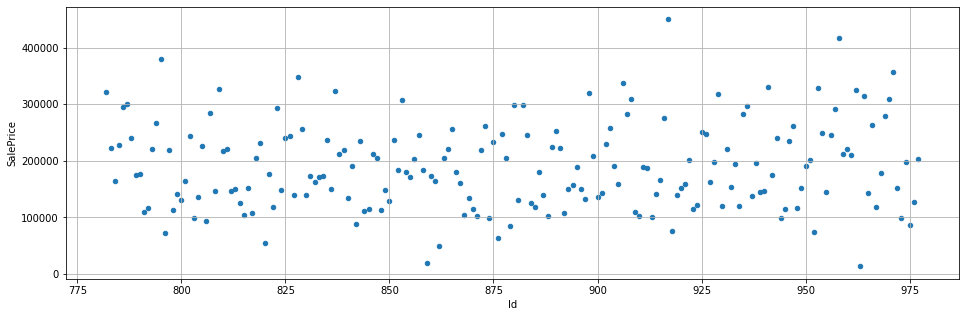

In [6]:
test_table = pd.read_csv('input/test.csv')


Xtest = test_table[['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']].to_numpy()

Xtest = (Xtest - Xtest.mean(axis = 0).reshape(1, Xtest.shape[1])) / Xtest.std(axis = 0).reshape(1, Xtest.shape[1])
Xtest[np.isnan(Xtest)] = 0

Xtest = np.insert(Xtest, 0, 1, axis = 1)


Ytest = pd.DataFrame(np.around(np.dot(Xtest, B)).astype(np.int64))
Ytest.columns = ['SalePrice']

Ans = pd.DataFrame(test_table.Id)
Ans['SalePrice'] = Ytest.SalePrice
Ans.to_csv("mytest.csv", sep = ',', columns = ['Id', 'SalePrice'], index = False)

fg = plt.figure(figsize=(16,5))
ax2 = plt.subplot(111)

print("Посмотрим на общий график значения цены:")
Ans.plot.scatter('Id', 'SalePrice', ax = ax2)
ax2.grid()

###### <center>Сделано Бронниковым Максимом</center>
###### <center>20.10.2019</center>